In [25]:
import pandas as pd
import numpy as np
import os

# Đọc dữ liệu users
def _read_users():
  users_cols = ['user_id', 'age', 'sex', 
                'occupation', 'zip_code']
  users = pd.read_csv('ml-100k/u.user', sep='|', 
                      names=users_cols, encoding='latin-1',
                      dtype={'user_id':str,
                             'age':str})
  return users

# Đọc dữ liệu ratings
def _read_ratings():
  ratings_cols = ['user_id', 'movie_id', 
                  'rating', 'unix_timestamp']
  ratings = pd.read_csv('ml-100k/u.data', sep='\t', 
                        names=ratings_cols, encoding='latin-1',
                        dtype={'user_id':str,
                               'movie_id':str})
  return ratings

# Đọc dữ liệu về các bộ phim
def _read_movies():
  genre_cols = ["genre_unknown", "Action", "Adventure", 
                "Animation", "Children", "Comedy", 
                "Crime", "Documentary", "Drama", 
                "Fantasy", "Film-Noir", "Horror", 
                "Musical", "Mystery", "Romance", 
                "Sci-Fi", "Thriller", "War", "Western"]
  movies_cols = ['movie_id', 'title', 'release_date', 
                 "video_release_date", "imdb_url"]
  all_movies_cols = movies_cols + genre_cols
  movies = pd.read_csv('ml-100k/u.item', sep='|', 
                       names=all_movies_cols, encoding='latin-1',
                       dtype={'movie_id':str})
  # Đánh dấu các dòng có tổng các thể loại phim genres = 0.
  count_genres = [0 if count >= 1 else 1 for count in movies[genre_cols].apply(sum, axis=1)]
  # Cập nhật những dòng có tổng genres = 0 giá trị cột genre_unknow = 1
  movies['genre_unknown'].iloc[count_genres] = 1
  movies['year'] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
  movies['year'] = [str(year) if year != 'nan' else '1996' for year in movies['year']]
  # Lấy list các genre của mỗi movies
  all_genres = []
  for i in range(movies.shape[0]):
    dict_count = dict(movies[genre_cols].iloc[i])
    genre_row = [genre for genre in dict_count if dict_count[genre] != 0]
    all_genres.append(genre_row)
  movies['all_genres'] = all_genres
  return movies

users = _read_users()
ratings = _read_ratings()
movies = _read_movies()

/var/folders/3r/9fvf4cpx6jjd1b07n6_49y4r0000gn/T/ipykernel_5055/2037997651.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['genre_unknown'].iloc[count_genres] = 1


<Axes: xlabel='rating', ylabel='Count'>

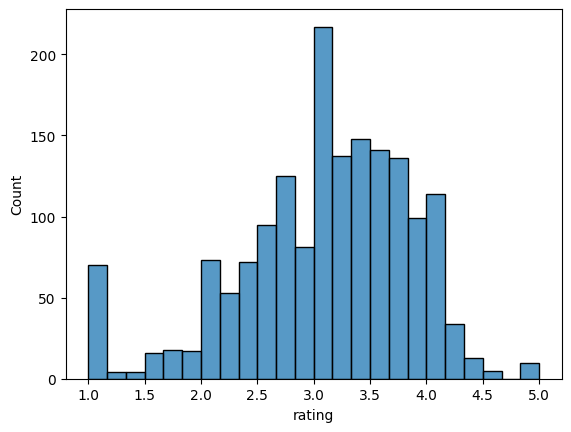

In [26]:
import seaborn as sns

avg_movie_rate = ratings.groupby('movie_id').rating.mean()
sns.histplot(avg_movie_rate)

<Axes: xlabel='rating', ylabel='Count'>

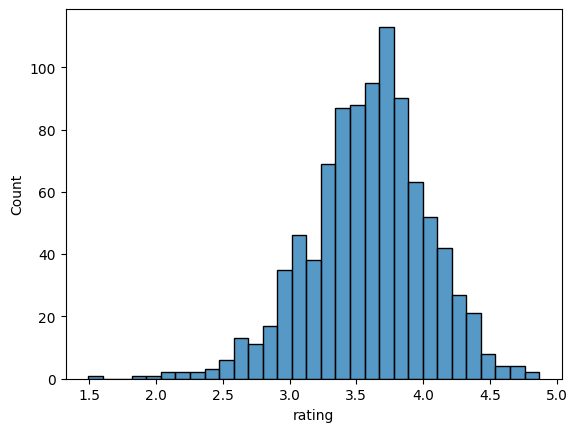

In [27]:
avg_user_rate = ratings.groupby('user_id').rating.mean()
sns.histplot(avg_user_rate)

<Axes: xlabel='age'>

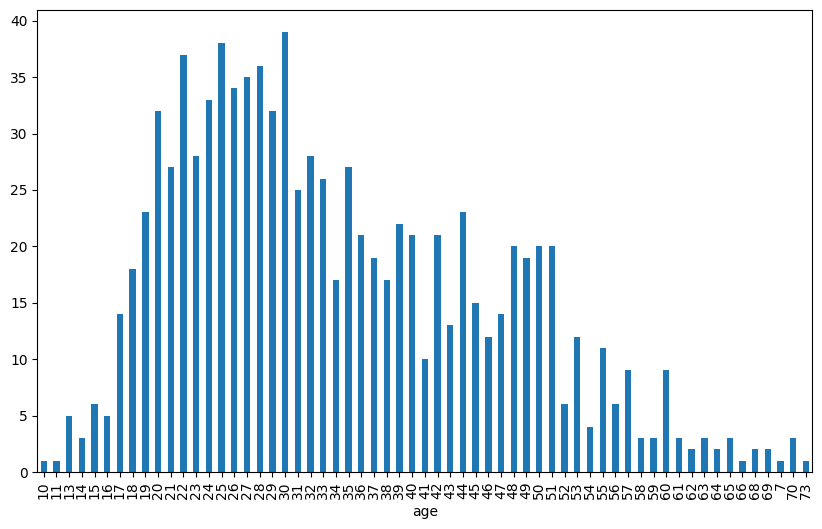

In [28]:
users.groupby('age').user_id.count().plot.bar(figsize=(10, 6))


<Axes: xlabel='occupation'>

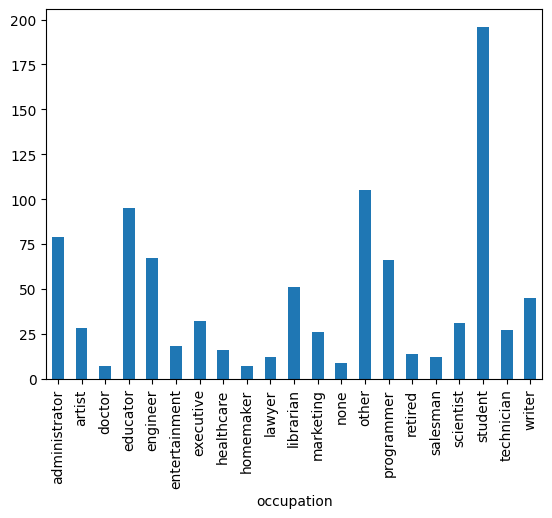

In [29]:
users.groupby('occupation').user_id.count().plot.bar()


In [30]:
# Hàm chia data thành tập train/test
def split_train_test(df, split_rate=0.2):
  """Chia dữ liệu dataframe thành tập train và test.
  Args:
    df: dataframe.t
    holdout_fraction: tỷ lệ số dòng của dataframe được sử dụng trong tập test.
  Returns:
    train: dataframe cho huấn luyện
    test: dataframe cho kiểm định
  """
  test = df.sample(frac=split_rate, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

In [31]:

user_rates = ratings.groupby('user_id').movie_id.apply(list).reset_index()
user_rates.head()

,user_id,movie_id
0,1,"[61, 189, 33, 160, 20, 202, 171, 265, 155, 117..."
1,10,"[16, 486, 175, 611, 7, 100, 461, 488, 285, 504..."
2,100,"[344, 354, 268, 321, 355, 750, 266, 288, 302, ..."
3,101,"[829, 304, 596, 222, 471, 405, 281, 252, 282, ..."
4,102,"[768, 823, 70, 515, 524, 322, 625, 161, 448, 4..."


In [32]:
import tensorflow as tf

# Dictionary của bộ phim và năm sản xuất
years_dict = {
    movie: year for movie, year in zip(movies["movie_id"], movies["year"])
}

# Dictionary của bộ phim tương ứng với thể loại
genres_dict = {
    movie: genres
    for movie, genres in zip(movies["movie_id"], movies["all_genres"])
}

# Dictionary của user:
user_dict = {
    user: {'age': age, 'sex': sex, 'occupation': occupation}
    for user, age, sex, occupation in zip(users["user_id"], users["age"], users["sex"], users["occupation"])
}

def data_gen_batch(user_rates, batch_size):
  """Khởi tạo ra một batch input chính là các movie embedding
  Argument:
    user_rates: DataFrame lịch sử các bộ phim đã rate của user sao cho cột "movie_id" là danh sách các bộ phim đã được rate bởi user.
    batch_size: Kích thước mẫu.
  """
  # Hàm pad để đưa các véc tơ category không có cùng kích thước của 1 biến về chung 1 kích thước.
  def pad(x, fill):
    return pd.DataFrame.from_dict(x).fillna(fill).values
  
  # list danh sách các movie_id mà user đã rate
  movie = []
  # year là năm sản suất của movie
  year = []
  # genre là thể loại phim
  genre = []
  # label là movie_id của bộ phim
  label = []
  # Các thông tin user:
  age = []
  sex = []
  occupation = []
  for i, (movie_ids, user_id) in user_rates[["movie_id", "user_id"]].iterrows():
    # Khởi tạo các thông tin liên quan đến movie
    n_movies = len(movie_ids)
    movie.append(movie_ids)
    genre.append([x for movie_id in movie_ids for x in genres_dict[movie_id]])
    year.append([years_dict[movie_id] for movie_id in movie_ids])
    # Lưu ý phải trừ đi label 1 đơn vị vì output mạng neural thì movied_id: 1-->0, 2-->1,...,
    label.append([int(movie_id)-1 for movie_id in movie_ids])
    # Khởi tạo các thông tin liên quan đến user
    age.append([user_dict[user_id]['age']]*n_movies)
    sex.append([user_dict[user_id]['sex']]*n_movies)
    occupation.append([user_dict[user_id]['occupation']]*n_movies)
  # Khởi tạo batch từ feature huấn luyện
  features = {
      'movie_id': pad(movie, ""),
      'genre': pad(genre, ""),
      'year': pad(year, ""),
      'age': pad(age, ""),
      'sex': pad(sex, ""),
      'occupation': pad(occupation, ""),
      'label': pad(label, -1)
  }
  batch = (
  tf.data.Dataset.from_tensor_slices(features)
      .shuffle(1000)
      .repeat()
      # Khai báo kích thước batch
      .batch(batch_size)
      # Khởi tạo vòng lặp iterator qua từng batch
      .make_one_shot_iterator()
      .get_next())
  return batch

def select_random(x):
  """Lựa chọn một số phần tử ngẫu nhiên từ mỗi một dòng của x."""
  def to_float(x):
    return tf.cast(x, tf.float32)
  def to_int(x):
    return tf.cast(x, tf.int64)
  batch_size = tf.shape(x)[0]
  # Trả về khoảng range từ 0 --> batch_size
  rn = tf.range(batch_size)
  # Đếm số lượng giá trị >= 0 của dòng x
  nnz = to_float(tf.count_nonzero(x >= 0, axis=1))
  # Trả về một chuỗi random có kích thước là batch_size và giá trị mỗi phần tử trong khoảng (0, 1)
  rnd = tf.random_uniform([batch_size])
  # Stack row indexes and column indexes
  # Khởi tạo list các ids gồm (index_row, index_col). 
  ids = tf.stack([to_int(rn), to_int(nnz * rnd)], axis=1)
  # Trích suất các index ngẫu nhiên từ x theo ids. Mỗi dòng sẽ lấy 1 phần tử là index của movie mà khách hàng đã rate.
  return to_int(tf.gather_nd(x, ids))

In [33]:
def loss_cross_entropy(user_embeddings, movie_embeddings, labels):
  """Trả về hàm cross-entropy loss function.
  Args:
    user_embeddings: một tensor shape [batch_size, embedding_dim].
    movie_embeddings: một tensor shape [num_movies, embedding_dim].
    labels: một sparse tensor có kích thước [batch_size, 1], tensor này chỉ lưu index của vị trí khác 0. 
    Chẳng hạn labels[i] là movie_id của bộ phim được rate của mẫu i.
  Returns:
    mean cross-entropy loss.
  """
  # Số chiều của user_embeddings phải bằng với movie_embeddings
  # assert user_embeddings.shape[1].value == movie_embeddings.shape[1].value
  # Tính giá trị logits
  logits = tf.matmul(user_embeddings, movie_embeddings, transpose_b=True)
  # Hàm loss function
  loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
      logits=logits, labels=labels))
  return loss

In [34]:
import tensorflow as tf
from keras.optimizers.legacy import SGD
import matplotlib.pyplot as plt
import collections

# Khởi tạo class RecNeuralNet hỗ trợ huấn luyện mô hình
class RecNeuralNet(object):
  """Một class biểu diễn mô hình collaborative filtering model"""
  def __init__(self, embedding_vars, loss, metrics=None):
    """Khởi tạo RecNeuralNet.
    Args:
      embedding_vars: Từ điển của các biến đầu vào. Định dạng tf.Variable().
      loss: Hàm loss function cần được tối ưu hóa. Định dạng float Tensor.
      metrics: Một list các dictionaries của các tensors. Các metrics trong mỗi dictionary sẽ được visualize trên các biểu đồ khác nhau 
      trong suốt quá trình huấn luyện.
    """
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    # Khởi tạo none embeddings dictionary
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    """trả về embeddings."""
    return self._embeddings

  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=SGD):
    """Huấn luyện model.
    Args:
      iterations: số lượng iterations huấn luyện.
      learning_rate: learning rate optimizer.
      plot_results: có vẽ biểu đồ sau khi huấn luyện xong mô hình hay không?
      optimizer: object optimizer được sử dụng để huấn luyện mô hình. Mặc định là GradientDescentOptimizer.
    Returns:
      Dictionary là các metrics được đánh giá tại vòng lặp cuối cùng.
    """
    # Khởi tạo các train_operation là quá trình tối thiểu hóa hàm loss function.
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()
          
    # Huấn luyện mô hình trong session
    with self._session.as_default():
      # Kích hoạt khởi tạo các biến local
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      # Huấn luyện mô hình và append results
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        # In ra kết quả các metrics sau mỗi 10 vòng lặp.
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)

          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      # Lưu các giá trị user_embedding, movie_embedding vào embedding dictionary
      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()
      # Vẽ biểu đồ các metrics được đo lường.
      if plot_results:
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

In [35]:
from keras.utils import FeatureSpace

def init_softmax_model(rated_movies, embedding_cols, hidden_dims):
  """Xây dựng mô hình Softmax cho MovieLens.
  Args:
    rated_movies: DataFrame chứa list các bộ phim mà user đã rate.
    embedding_cols: là list các dictionary sao cho mỗi một dictionary mapping các feature names vào các véc tơ embedding của input dataframe. 
    list các dictionaries này sẽ được sử dụng trong tf.feature_column.input_layer() để khởi tạo input layer nhằm 
    mapping sparse input features --> input embeddings như hình vẽ kiến trúc mô hình.
    hidden_dims: list các kích thước của lần lượt các hidden layers.
  Returns:
    một RecNeuralNet object.
  """
  def user_embedding_network(features):
    """Maps input features dictionary với user embeddings.
    Args:
      features: một dictionary của input dạng string tensors.
    Returns:
      outputs: một tensor shape [batch_size, embedding_dim].
    """
    # Khởi tạo một bag-of-words embedding cho mỗi sparse features thông qua embedding_cols
    # Ở đây ta sử dụng một thủ thuật nhúng các biến category thành các one-hot và sau đó concatenate chúng ở đầu vào thông qua hàm tf.feature_column.input_layer(features, embedding_cols)
    feature_space = FeatureSpace(
      features={
          "float_values": "float_normalized",
          "string_values": "string_categorical",
          "int_values": "integer_categorical",
      },
      crosses=[("string_values", "int_values")],
      output_mode="concat",
  )
    inputs = feature_space.adapt(features)
    # Hidden layers.
    input_dim = inputs.shape[1].value
    for i, output_dim in enumerate(hidden_dims):
      w = tf.get_variable(
          "hidden%d_w_" % i, shape=[input_dim, output_dim],
          initializer=tf.truncated_normal_initializer(
              stddev=1./np.sqrt(output_dim))) / 10.
      outputs = tf.matmul(inputs, w)
      input_dim = output_dim
      inputs = outputs
    return outputs

  train_rated_movies, test_rated_movies = split_train_test(rated_movies)
  # Khởi tạo các movie embedding trên train/test
  train_batch = data_gen_batch(train_rated_movies, 128)
  test_batch = data_gen_batch(test_rated_movies, 64)

  # Khởi tạo variable_scope để tái sử dụng lại các biến của nó
  with tf.variable_scope("model", reuse=False):
    # Tạo véc tơ nhúng user embedding
    train_user_embeddings = user_embedding_network(train_batch)
    # Lấy ngẫu nhiên label từ batch size
    train_labels = select_random(train_batch["label"])
  with tf.variable_scope("model", reuse=True):
    # Tạo véc tơ nhúng user embedding
    test_user_embeddings = user_embedding_network(test_batch)
    # Lấy ngẫu nhiên label từ test batch
    test_labels = select_random(test_batch["label"])
    # Trích xuất các movie_embeddings là layer cuối cùng của mạng neural
    # Lấy variable movie_embeddings có tên như bên dưới hoặc tạo movie_embeddings variable nếu nó chưa tồn tại
    movie_embeddings = tf.get_variable(
        "input_layer/movie_id_embedding/embedding_weights")
  
  # Xây dựng các hàm loss function trên train và test từ các đầu vào đã biết là user_embeddings, movie_embeddings (chính là các batch) và labels
  train_loss = loss_cross_entropy(train_user_embeddings, movie_embeddings, train_labels)
  test_loss = loss_cross_entropy(test_user_embeddings, movie_embeddings, test_labels)
  # Kiểm tra độ chính xác trên tập test chỉ tại k class có xác suất dự báo lớn nhất. 
  _, test_precision_at_10 = tf.metrics.precision_at_k(
      labels = test_labels,
      predictions = tf.matmul(test_user_embeddings, movie_embeddings, transpose_b=True),
      k=10
  )

  metrics = (
      {"train_loss": train_loss, "test_loss": test_loss},
      {"test_precision_at_10": test_precision_at_10}
  )
  embeddings = {"movie_id": movie_embeddings,
                "user_id": train_user_embeddings}
  return RecNeuralNet(embeddings, train_loss, metrics)


In [36]:
# Khởi tạo hàm số giúp embedding các category sang véc tơ embedding.
def _embedding_category_col(key, embedding_dim, table_name = 'movies'):
  """
  key: tên cột dạng category cần khởi tạo vocabulary, tên cột phải trùng với tên các key trong features dict của batch
  embedding_dim: số chiều dữ liệu được sử dụng để nhúng các categorical_column
  """
  if table_name == 'movies':
    # Khởi tạo vocabulary cho các giá trị của column key.
    if key == 'genre':
      list_gens = list(set([gen for movie_gens in movies['all_genres'] for gen in movie_gens]))
      categorical_col = tf.feature_column.categorical_column_with_vocabulary_list(
        key=key, vocabulary_list=list_gens, num_oov_buckets=0)
    else:
      categorical_col = tf.feature_column.categorical_column_with_vocabulary_list(
          key=key, vocabulary_list=list(set(movies[key].values)), num_oov_buckets=0)
  elif table_name == 'users':
    categorical_col = tf.feature_column.categorical_column_with_vocabulary_list(
        key=key, vocabulary_list=list(set(users[key].values)), num_oov_buckets=0)
  # Trả về embedding véc tơ từ dictionary.
  return tf.feature_column.embedding_column(
      categorical_column=categorical_col, dimension=embedding_dim,
      combiner='mean')

with tf.Graph().as_default():
  softmax_model = init_softmax_model(
      user_rates,
      embedding_cols=[
          _embedding_category_col("movie_id", 35),
          _embedding_category_col("genre", 3),
          _embedding_category_col("year", 2),
          _embedding_category_col("age", 3, "users"),
          _embedding_category_col("sex", 2, "users"),
          _embedding_category_col("occupation", 3, "users")
      ],
      hidden_dims=[35])

softmax_model.train(learning_rate=5., num_iterations=2000, optimizer=tf.train.AdagradOptimizer)

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


AttributeError: '_BatchDataset' object has no attribute 'make_one_shot_iterator'

In [ ]:
DOT = 'dot'
COSINE = 'cosine'
def _compute_similarity(query_embedding, item_embeddings, measure=DOT):
  """Tính điểm số giữa câu query và item embedding.
  Args:
    query_embedding: là một vector nhúng của query kích thước [k].
    item_embeddings: là ma trận nhúng véc tơ các items kích thước [N, k].
    measure: là một chuỗi string xác định kiểu đo lường tương đương được sử dụng. Có thể là theo phương pháp 'dot similarity' hoặc 'cosine similarity'.
  Returns:
    scores: một véc tơ kích thước [N], sao cho score[i] là điểm của item i được cho bởi query.
  """
  u = query_embedding
  V = item_embeddings
  if measure == COSINE:
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    u = u / np.linalg.norm(u)
  scores = u.dot(V.T)
  return scores

In [ ]:
def _movie_similarity(model, movie_id, measure=DOT, k=10):
  # Lọc ra title của bộ phim
  titles = movies[movies['movie_id']==str(movie_id)]['title'].values
  print('movie title: {}'.format(titles))
  if len(titles) == 0:
    raise ValueError("Found no movies with movie_id %s" % movie_id)
  print("Nearest neighbors of : %s." % titles[0])
  scores = compute_scores(
      model.embeddings["movie_id"][movie_id], model.embeddings["movie_id"],
      measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
      'titles': movies['title'],
      'genres': movies['all_genres']
  })
  return df.sort_values([score_key], ascending=False).head(k)

In [ ]:
_movie_similarity(softmax_model, movie_id=666, measure=COSINE, k=20)

In [ ]:
from sklearn.manifold import TSNE
import time

X = softmax_model.embeddings['movie_id']

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
X2D = tsne.fit_transform(X)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [ ]:
# Lựa chọn ngẫu nhiên một thể loại phim trong trường hợp thể loại phim là 1 list
y = [np.random.choice(genres) for genres in movies['all_genres']]
print('y.shape: {}'.format(len(y)))
print('X2D.shape: {}'.format(X2D.shape))

In [ ]:
genres = list(set(y))
N = len(genres)

def get_cmap(n, name='hsv'):
    '''Trả về một hàm số map mỗi index trong khoảng từ 0, 1, ..., n-1 đến các mã màu RGB;
    Giá trị của đối số name phải trùng với tên colormap của mã màu chuẩn mpl, chẳng hạn hsv'''
    return plt.cm.get_cmap(name, n)
cmap = get_cmap(N)

In [ ]:
# Hàm lọc các index thuộc về một thể loại phim genre
def _filter_genre_id(y, genre):
  return [True if item == genre else False for item in y]

# Vẽ biểu đồ
plt.figure(figsize = (12, 8))
for i, genre in enumerate(genres):
  ids = _filter_genre_id(y, genre)
  plt.scatter(X2D[ids, 0], X2D[ids, 1], s=50, c=cmap(i), label=genre)
plt.title('Group of Genre according to 2D embedding vector')
plt.xlabel('tsne-2d-one')
plt.ylabel('tsne-2d-two')
plt.legend()
plt.show()

In [ ]:
genres=['Children', 'Animation', 'Action', 'Horror', 'Musical']

plt.figure(figsize = (12, 8))
for i, genre in enumerate(genres):
  ids = _filter_genre_id(y, genre)
  plt.scatter(X2D[ids, 0], X2D[ids, 1], s=50, c=cmap(i), label=genre)
plt.title('Group of Genre according to 2D embedding vector')
plt.xlabel('tsne-2d-one')
plt.ylabel('tsne-2d-two')
plt.legend()
plt.show()